In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Читаем таблицу и добавляем названия признаков:

In [2]:
data = pd.read_csv("car.data", header = None,
    names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])

In [3]:
data.shape

(1728, 7)

Видим, что все признаки категориальные и нет пропусков данных:

In [4]:
data.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object

In [5]:
data.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [6]:
data.describe(include=[object])

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,low,low,4,more,small,low,unacc
freq,432,432,432,576,576,576,1210


Видим дисбалланс классов (для решаюших деревьев это не критично):

In [7]:
data['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

## ML

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

Выделяем и кодируем признаковые переменные и создаем целевую переменную.

In [9]:
X = data.drop(['class'], axis = 1).apply(LabelEncoder().fit_transform) 
y = data['class']

In [10]:
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,3,3,0,0,2,1
1,3,3,0,0,2,2
2,3,3,0,0,2,0
3,3,3,0,0,1,1
4,3,3,0,0,1,2


In [11]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

### DT

Сначала применим DecisionTreeClassifier с настройками "из коробки" - чтобы оценить "масштаб проблемы":

In [12]:
tree_clf = DecisionTreeClassifier(random_state = 42)

In [13]:
tree_clf.fit(XTrain, yTrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [14]:
yPredTree = tree_clf.predict(XTest)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
print(classification_report(yTest, yPredTree))

              precision    recall  f1-score   support

         acc       0.93      0.97      0.95       115
        good       0.91      1.00      0.95        21
       unacc       1.00      0.98      0.99       363
       vgood       1.00      0.95      0.97        20

    accuracy                           0.98       519
   macro avg       0.96      0.98      0.97       519
weighted avg       0.98      0.98      0.98       519



Вроде бы неплохой результат.

In [19]:
cm = confusion_matrix(yTest, yPredTree)
Class = data['class'].value_counts().index.tolist()
pd.DataFrame(cm, Class, Class)

,unacc,acc,good,vgood
unacc,112,2,1,0
acc,0,21,0,0
good,7,0,356,0
vgood,1,0,0,19


In [20]:
importances = list(zip(tree_clf.feature_importances_, X.columns))
importances.sort(reverse = True)

In [21]:
importances

[(0.25173880974355667, 'safety'),
 (0.19959540478261917, 'maint'),
 (0.1896704554460391, 'persons'),
 (0.18693526295658172, 'buying'),
 (0.11289102638070807, 'lug_boot'),
 (0.059169040690495125, 'doors')]

### Bagging

Теперь применим busting для алгоритма решающего дерева с тем же набором параметров. 

In [22]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    n_jobs=-1, 
    random_state=42,
    oob_score=True
)
bag_clf.fit(XTrain, yTrain)
yPredBag = bag_clf.predict(XTest)

Посмотрим на внутреннюю оut-of-bag-оценку качества алгоритма:

In [23]:
bag_clf.oob_score_

0.978494623655914

In [24]:
print(classification_report(yTest, yPredBag))

              precision    recall  f1-score   support

         acc       0.94      0.97      0.96       115
        good       0.91      1.00      0.95        21
       unacc       0.99      0.98      0.99       363
       vgood       1.00      0.90      0.95        20

    accuracy                           0.98       519
   macro avg       0.96      0.96      0.96       519
weighted avg       0.98      0.98      0.98       519



In [25]:
cm = confusion_matrix(yTest, yPredBag)
Class = data['class'].value_counts().index.tolist()
df_cm = pd.DataFrame(cm, Class, Class)

Матрица ошибок показывает, что качество классификации немного улучшилось.

In [27]:
df_cm

,unacc,acc,good,vgood
unacc,112,1,2,0
acc,0,21,0,0
good,6,0,357,0
vgood,1,1,0,18


## RF

Теперь будем выбирать случайный лес среди семейства случайных лесов, определенных заданным набором параметров.

In [28]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

In [29]:
yTrain = yTrain.tolist()

Количество деревьев в лесе будем брать равным 100, 500 и 1000.
Критерии расщепления - "gini" и "entropy".
Число признаков для выбора расщепления возьмем равным  2, 3, 4, 5 и 6.
Минимальное число объектов, при котором выполняется расщепление - 2 и 3.
Ограничение на число объектов в листьях - 1 и 2.

In [30]:
gridParams = {
     'n_estimators': [100, 500, 1000],
     'criterion': ['gini', 'entropy'],
     'max_features' : range(2, 7),
     'min_samples_split' : [2,3],
     'min_samples_leaf' : [1,2]
}
kf = KFold(shuffle=True, random_state=42)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


In [31]:
grid = GridSearchCV(RandomForestClassifier(random_state = 42, verbose = 3, n_jobs = -1, oob_score=True),
    param_grid = gridParams, cv = kf, verbose=3, n_jobs = -1)

In [32]:
grid.fit(XTrain, yTrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  8.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100building tree 17 of 100

building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100building tree 41 of 100

building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s


building tree 50 of 100
building tree 51 of 100building tree 52 of 100

building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100building tree 67 of 100

building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100building tree 86 of 100

building tree 87 of 100
building tree 88 of 100
building tree 89 of 100building tree 90 of 100

building tree 91

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=True, random_state=42,
                                              verbose=3, warm_start=False),
       

In [33]:
grid.best_params_

{'criterion': 'entropy',
 'max_features': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [34]:
bestRF = grid.best_estimator_
bestRF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=3,
                       warm_start=False)

In [35]:
bestRF.oob_score_

0.9834574028122415

In [36]:
yPredRF = bestRF.predict(XTest)
print(classification_report(yTest, yPredRF))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         acc       0.96      0.97      0.97       115
        good       0.95      1.00      0.98        21
       unacc       0.99      0.99      0.99       363
       vgood       1.00      1.00      1.00        20

    accuracy                           0.98       519
   macro avg       0.98      0.99      0.98       519
weighted avg       0.98      0.98      0.98       519



In [37]:
cm = confusion_matrix(yTest, yPredRF)
Class = data['class'].value_counts().index.tolist()
pd.DataFrame(cm, Class, Class)

,unacc,acc,good,vgood
unacc,112,1,2,0
acc,0,21,0,0
good,5,0,358,0
vgood,0,0,0,20


Матрица ошибок показывает, что качество классификации еще улучшилось.

In [38]:
importances = list(zip(bestRF.feature_importances_, X.columns))
importances.sort(reverse = True)

importances

[(0.2548994568521572, 'safety'),
 (0.20285568592386533, 'persons'),
 (0.1977830672991718, 'maint'),
 (0.17827769925675127, 'buying'),
 (0.10532927644066359, 'lug_boot'),
 (0.06085481422739091, 'doors')]

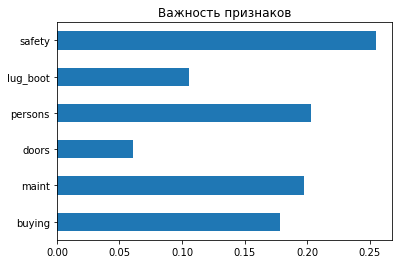

In [39]:
pd.DataFrame(bestRF.feature_importances_,X.columns).plot(kind='barh', legend= False, title = 'Важность признаков')